## KoopSTD Analysis of LLM Hidden Representations

In this notebook, we demonstrate how our proposed **KoopSTD** provides a new perspective on understanding LLM scaling laws.

### Experimental Setup

We conduct the following experiment:
- **Dataset**: Randomly select 10 instructions from the `databricks-dolly-15k` dataset
- **Models**: Four different sizes of GPT-2 models (mini, medium, large, xl)
- **Inference**: Each model processes each instruction 5 times independently
- **Analysis**: Extract last layer hidden states and apply KoopSTD to evaluate their dynamics distances 

In [ ]:
import os
import torch
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
import pandas as pd

max_length = 100

def get_inputs():
    import random
    df = pd.read_csv('./saved/databricks-dolly-15k.csv')  # from https://huggingface.co/datasets/databricks/databricks-dolly-15k
    first_column = df.iloc[:, 0] 
    texts = []
    for _ in range(10):
        texts.append(random.choice(first_column.dropna().tolist()))
    return texts

def gpt2_inference(model_index, batch_texts, runs):
    names = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
    prefix = ['mini', 'medium', 'large', 'xl']
    tokenizer = GPT2Tokenizer.from_pretrained(names[model_index])
    model = GPT2Model.from_pretrained(names[model_index])
    model = model.to('cuda')
    model.eval()
    for i, text in enumerate(batch_texts):
        input_ids = tokenizer(text, return_tensors="pt")["input_ids"].to('cuda')
        if input_ids.shape[1] > max_length-1:
            input_ids = input_ids[:, 0:max_length-1]
        trial_representation = []
        for j in range(runs):
            print(f"Inference on sample {i}, run {j}")
            generated_ids = input_ids.clone()
            for _ in range(max_length - input_ids.shape[1]):
                outputs = model(input_ids=generated_ids)
                hidden_states = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
                last_hidden_state = hidden_states[:, -1, :]  # Shape: [batch_size, hidden_dim]
                # Project the hidden state to vocabulary size
                # Use the embedding matrix as the projection matrix (tied weights assumption)
                logits = torch.matmul(last_hidden_state, model.wte.weight.T)  # Shape: [batch_size, vocab_size]
                probs = torch.nn.functional.softmax(logits, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)  # Shape: [batch_size, 1]
                generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)   
            trial_representation.append(hidden_states.detach().cpu().numpy())
            generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        np.save(f'./saved/gpt2_75/{prefix[model_index]}_{i}.npy', np.array(trial_representation).squeeze())

instructions = get_inputs()
# gpt2: mini, medium, large, xl
for m in range(4):
    gpt2_inference(m, instructions, 5)

We collected a total of **200 hidden states** from our experiments:
- **4 GPT-2 models** (mini, medium, large, xl)
- **10 instruction samples** per model
- **5 inference runs** per sample

Each hidden state has dimensions `[99, 768]`:
- **99**: sequence length (tokens)
- **768**: hidden dimension size

In [14]:
from koopstd.dynametric import KoopOpMetric
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, MDS
import pandas as pd
import numpy as np

data = []
model_names = ['mini', 'medium', 'large', 'xl']
for name in model_names:
    for i in range(10):
        for d in np.load(f'./saved/gpt2_75/{name}_{i}.npy'):
            data.append(d)
len(data), data[0].shape

(200, (99, 768))

Next, we use KoopSTD to compute the distances between the dynamics of different models. 

The original data dimensions are preserved without any reduction.

In [10]:
koopstd_params = {'hop_size': 1, 'win_len': 150, 'rank': 10, 'lamb': 0} 
wasserstein_params = {'p': 1, 'method': 'emd'}
koopstd = KoopOpMetric(X=data, kmd_method='koopstd', kmd_params=koopstd_params, dist='wasserstein', dist_params=wasserstein_params, device='cuda')
koopstd_dist_matrix = koopstd.fit_score()

As model scale increases, representation dynamics become significantly more coherent and stable. Larger models (Large, xLarge) exhibit tightly clustered dynamical patterns regardless of input variations or random seeds, while smaller models (Mini, Medium) show greater dispersion and sensitivity to these factors. This reveals a fundamental scaling law: **larger language models develop more robust and consistent internal dynamics**.

More details please refer to our paper.

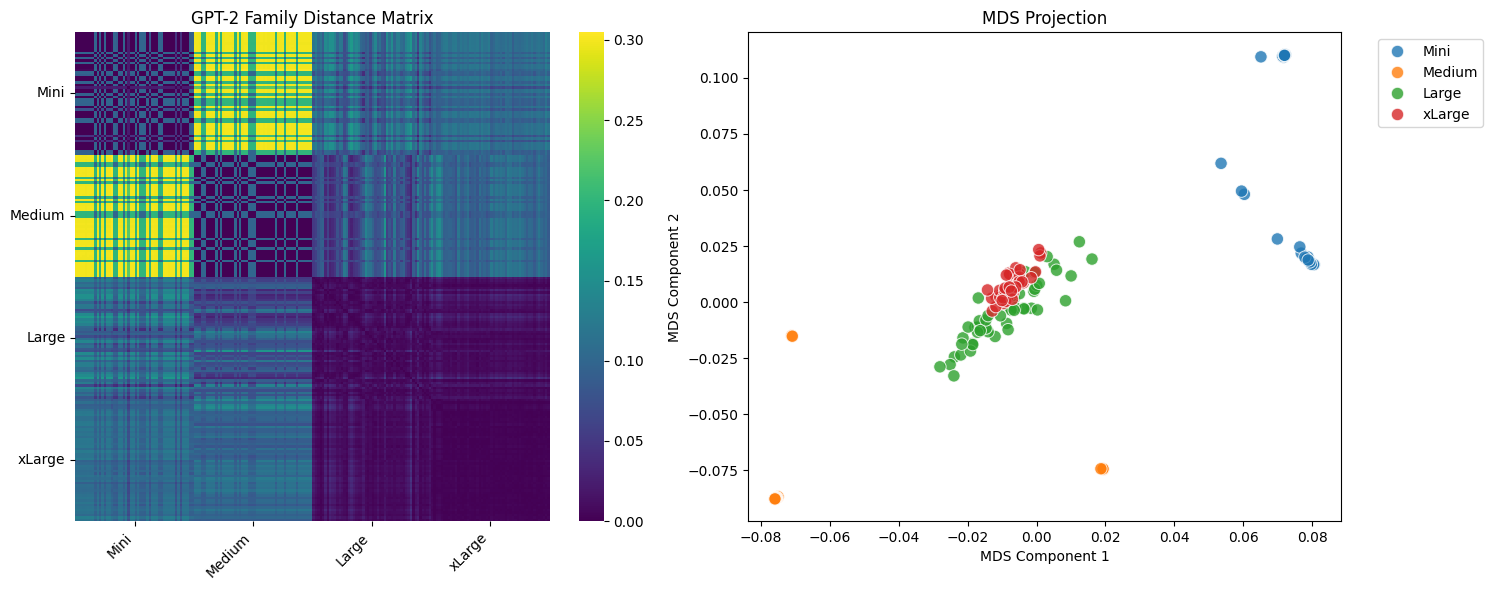

In [13]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot heatmap
sns.heatmap(koopstd_dist_matrix, cmap='viridis', ax=axes[0])
model_names = ['Mini', 'Medium', 'Large', 'xLarge']
axes[0].set_title('GPT-2 Family Distance Matrix')

# Set custom tick labels
tick_positions = [25, 75, 125, 175] 
axes[0].set_xticks(tick_positions)
axes[0].set_yticks(tick_positions)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].set_yticklabels(model_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(koopstd_dist_matrix)

# Create DataFrame for scatter plot
df = pd.DataFrame()
df["x"] = embedding[:, 0]
df["y"] = embedding[:, 1]
system_labels = []
for model_name in model_names:
    system_labels.extend([model_name] * 50) 
df["System"] = system_labels

# Plot scatter with improved styling
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[1], s=80, alpha=0.8)
axes[1].set_title('MDS Projection')
axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()